# Deep learning examples

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/NN_examples.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebooks contains examples with neural network models.

**Table of Contents**

* [Creating TSDataset](#chapter1)  
* [Architecture](#chapter2)
* [Testing models](#chapter3)
    * [DeepAR](#section_3_1)
    * [TFT](#section_3_2)
    * [Simple Model](#section_3_3)
* [Etna native deep models](#chapter4)

In [1]:
import torch
import random

import pandas as pd
import numpy as np

from etna.datasets.tsdataset import TSDataset
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.metrics import SMAPE, MAPE, MAE
from etna.analysis import plot_backtest
from etna.models import SeasonalMovingAverageModel

import warnings

warnings.filterwarnings("ignore")

/Users/marti/Library/Caches/pypoetry/virtualenvs/etna-LkP65DRT-py3.9/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


## 1. Creating TSDataset <a class="anchor" id="chapter1"></a>

We are going to take some toy dataset. Let's load and look at it.

In [2]:
original_df = pd.read_csv("data/example_dataset.csv")
original_df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


Our library works with the spacial data structure TSDataset. Let's create it as it was done in "Get started" notebook.

In [3]:
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq="D")
ts.head(5)

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


## 2. Architecture <a class="anchor" id="chapter2"></a>

Our library uses [PyTorch Forecasting](https://github.com/jdb78/pytorch-forecasting) to work with time series neural networks. To include it in our current architecture we use `PytorchForecastingDatasetBuilder` class.

Let's look at it closer.

In [4]:
from etna.models.nn.utils import PytorchForecastingDatasetBuilder

In [5]:
?PytorchForecastingDatasetBuilder

Init signature:
PytorchForecastingDatasetBuilder(
    max_encoder_length: int = 30,
    min_encoder_length: Optional[int] = None,
    min_prediction_idx: Optional[int] = None,
    min_prediction_length: Optional[int] = None,
    max_prediction_length: int = 1,
    static_categoricals: Optional[List[str]] = None,
    static_reals: Optional[List[str]] = None,
    time_varying_known_categoricals: Optional[List[str]] = None,
    time_varying_known_reals: Optional[List[str]] = None,
    time_varying_unknown_categoricals: Optional[List[str]] = None,
    time_varying_unknown_reals: Optional[List[str]] = None,
    variable_groups: Optional[Dict[str, List[int]]] = None,
    constant_fill_strategy: Optional[Dict[str, Union[str, float, int, bool]]] = None,
    allow_missing_timesteps: bool = True,
    lags: Optional[Dict[str, List[int]]] = None,
    add_relative_time_idx: bool = True,
    add_target_scales: bool = True,
    add_encoder_length: Union[bool, str] = True,
    target_normalizer: Union

We can see a pretty scary signature, but don't panic, we will look at the most important parameters. 

* `time_varying_known_reals` &mdash; known real values that change across the time (real regressors), now it it necessary to add "time_idx" variable to the list;
* `time_varying_unknown_reals` &mdash; our real value target, set it to `["target"]`;
* `max_prediction_length` &mdash; our horizon for forecasting;
* `max_encoder_length` &mdash; length of past context to use;
* `static_categoricals` &mdash; static categorical values, for example, if we use multiple segments it can be some its characteristics including identifier: "segment";
* `time_varying_known_categoricals` &mdash; known categorical values that change across the time (categorical regressors);
* `target_normalizer` &mdash; class for normalization targets across different segments.

Our library currently supports these models:
* [DeepAR](https://arxiv.org/abs/1704.04110),
* [TFT](https://arxiv.org/abs/1912.09363).

## 3. Testing models <a class="anchor" id="chapter3"></a>

In this section we will test our models on example.

### 3.1 DeepAR <a class="anchor" id="section_3_1"></a>

Before training let's fix seeds for reproducibility.

In [6]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

Creating transforms for DeepAR.

In [7]:
from pytorch_forecasting.data import GroupNormalizer

HORIZON = 7

transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
num_lags = 10
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]

dataset_builder_deepar = PytorchForecastingDatasetBuilder(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=["time_idx"] + lag_columns,
    time_varying_unknown_reals=["target"],
    time_varying_known_categoricals=["dateflag_day_number_in_week"],
    target_normalizer=GroupNormalizer(groups=["segment"]),
)

Now we are going to start backtest.

In [8]:
from etna.models.nn import DeepARModel


model_deepar = DeepARModel(
    dataset_builder=dataset_builder_deepar,
    trainer_params=dict(max_epochs=150, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)
metrics = [SMAPE(), MAPE(), MAE()]

pipeline_deepar = Pipeline(
    model=model_deepar,
    horizon=HORIZON,
    transforms=[transform_lag, transform_date],
)

In [9]:
metrics_deepar, forecast_deepar, fold_info_deepar = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.6min finished


Let's compare results across different segments.

In [10]:
metrics_deepar

,segment,SMAPE,MAPE,MAE,fold_number
3,segment_a,7.814027,7.459734,40.393350,0
3,segment_a,2.920063,2.877443,15.842041,1
3,segment_a,7.900175,7.524684,42.506601,2
2,segment_b,6.273518,6.073471,15.615123,0
2,segment_b,4.650930,4.489279,11.729834,1
2,segment_b,3.321330,3.327387,7.786599,2
1,segment_c,3.465609,3.406912,5.928299,0
1,segment_c,5.709281,5.528204,10.160797,1
1,segment_c,4.395517,4.327057,7.911656,2
0,segment_d,4.286527,4.364295,35.523158,0


To summarize it we will take mean value of SMAPE metric because it is scale tolerant.

In [11]:
score = metrics_deepar["SMAPE"].mean()
print(f"Average SMAPE for DeepAR: {score:.3f}")

Average SMAPE for DeepAR: 5.050


Visualize results.

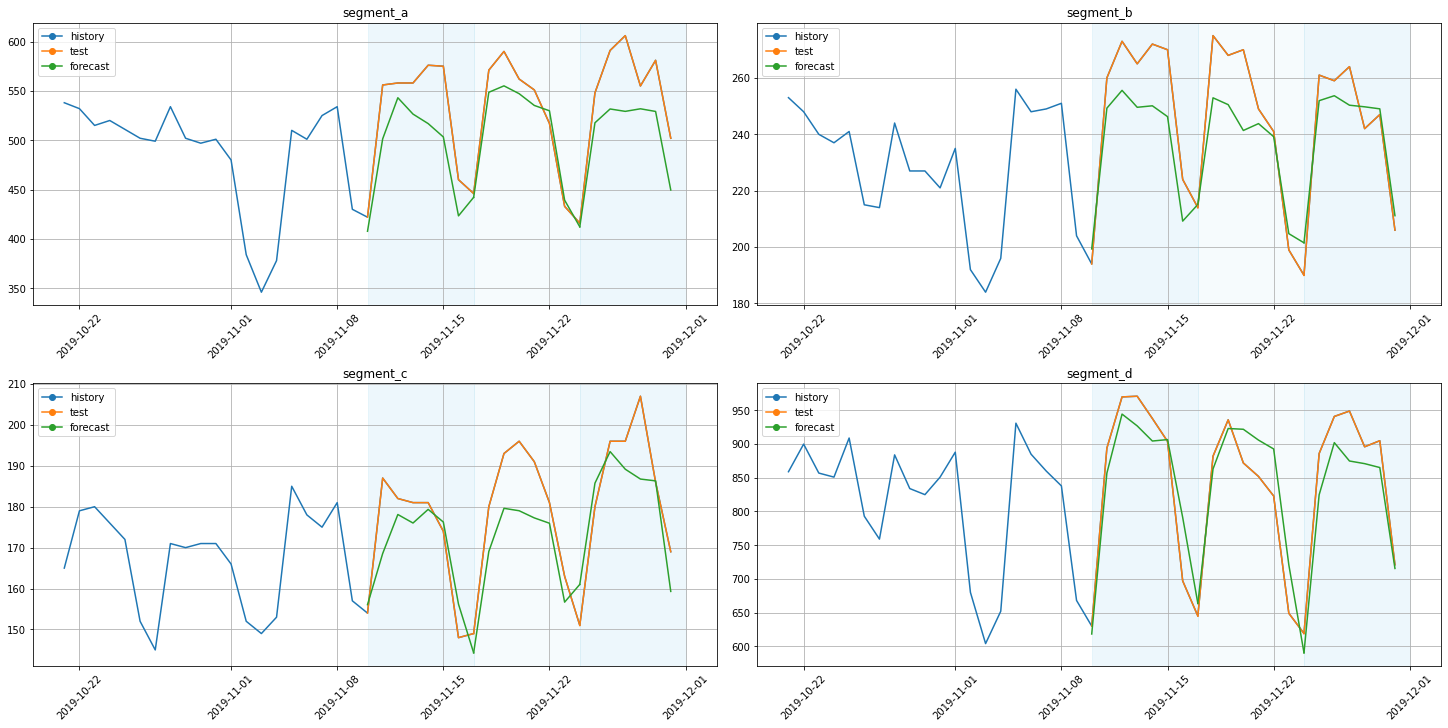

In [12]:
plot_backtest(forecast_deepar, ts, history_len=20)

### 3.2 TFT <a class="anchor" id="section_3_2"></a>

Let's move to the next model.

In [13]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [14]:
transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
num_lags = 10
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]

dataset_builder_tft = PytorchForecastingDatasetBuilder(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["target"],
    time_varying_known_categoricals=["dateflag_day_number_in_week"],
    static_categoricals=["segment"],
    target_normalizer=GroupNormalizer(groups=["segment"]),
)

In [15]:
from etna.models.nn import TFTModel

model_tft = TFTModel(
    dataset_builder=dataset_builder_tft,
    trainer_params=dict(max_epochs=200, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)

pipeline_tft = Pipeline(
    model=model_tft,
    horizon=HORIZON,
    transforms=[transform_lag, transform_date],
)

In [16]:
metrics_tft, forecast_tft, fold_info_tft = pipeline_tft.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 47    
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_c

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 47    
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | Variab

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.5min remaining:    0.0s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 47    
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | Variab

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.2min finished


In [17]:
metrics_tft

,segment,SMAPE,MAPE,MAE,fold_number
3,segment_a,4.909472,4.770604,26.157928,0
3,segment_a,10.161843,9.648282,51.786006,1
3,segment_a,7.775577,7.438396,41.532362,2
2,segment_b,6.654099,6.395358,16.623533,0
2,segment_b,7.753074,7.229456,19.099444,1
2,segment_b,3.309338,3.356554,8.014324,2
1,segment_c,5.110395,4.988732,8.812023,0
1,segment_c,5.470811,5.283700,9.889158,1
1,segment_c,3.135104,3.050495,5.756559,2
0,segment_d,7.421877,7.121675,64.413321,0


In [18]:
score = metrics_tft["SMAPE"].mean()
print(f"Average SMAPE for TFT: {score:.3f}")

Average SMAPE for TFT: 5.933


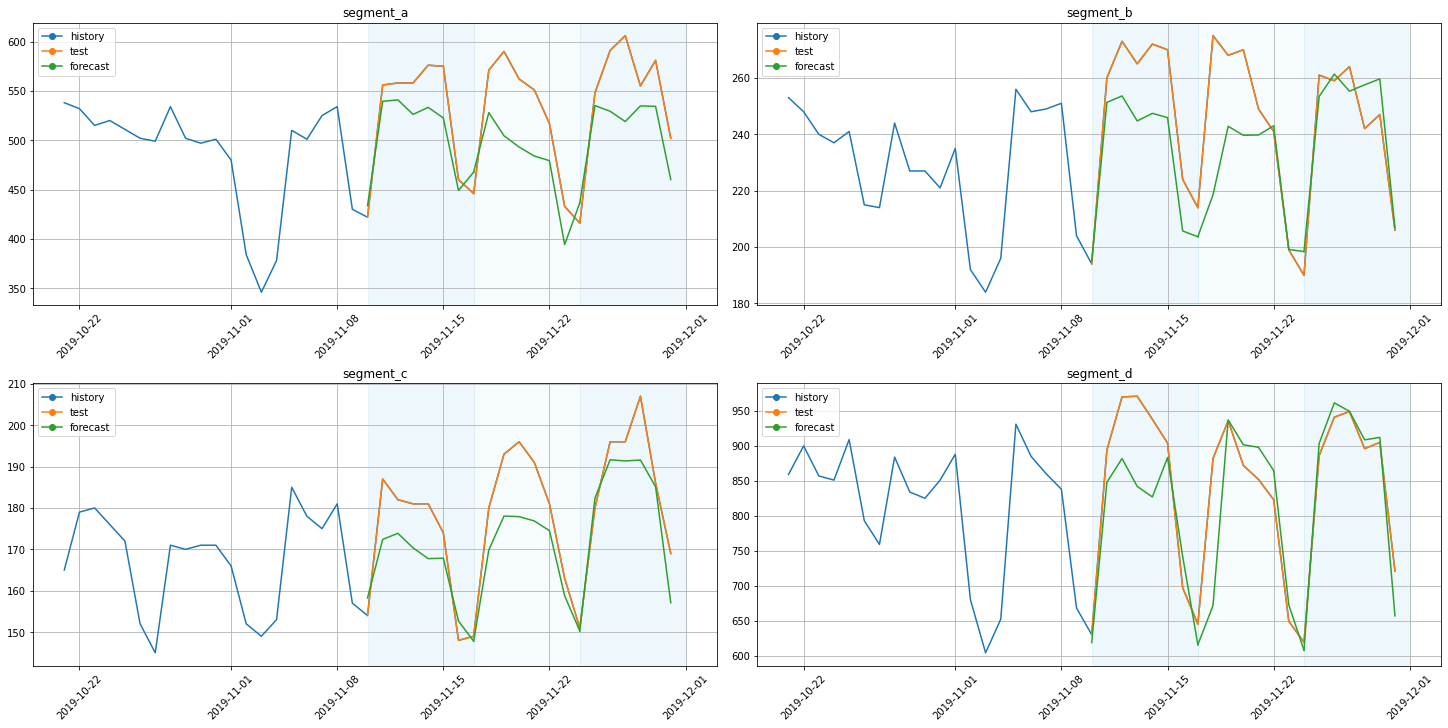

In [19]:
plot_backtest(forecast_tft, ts, history_len=20)

### 3.3 Simple model <a class="anchor" id="section_3_3"></a>

For comparison let's train a much more simpler model.

In [20]:
model_sma = SeasonalMovingAverageModel(window=5, seasonality=7)
linear_trend_transform = LinearTrendTransform(in_column="target")

pipeline_sma = Pipeline(model=model_sma, horizon=HORIZON, transforms=[linear_trend_transform])

In [21]:
metrics_sma, forecast_sma, fold_info_sma = pipeline_sma.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


In [22]:
metrics_sma

,segment,SMAPE,MAPE,MAE,fold_number
3,segment_a,6.343943,6.124296,33.196532,0
3,segment_a,5.346946,5.192455,27.938101,1
3,segment_a,7.510347,7.189999,40.028565,2
2,segment_b,7.178822,6.920176,17.818102,0
2,segment_b,5.672504,5.554555,13.719200,1
2,segment_b,3.327846,3.359712,7.680919,2
1,segment_c,6.430429,6.200580,10.877718,0
1,segment_c,5.947090,5.727531,10.701336,1
1,segment_c,6.186545,5.943679,11.359563,2
0,segment_d,4.707899,4.644170,39.918646,0


In [23]:
score = metrics_sma["SMAPE"].mean()
print(f"Average SMAPE for Seasonal MA: {score:.3f}")

Average SMAPE for Seasonal MA: 5.547


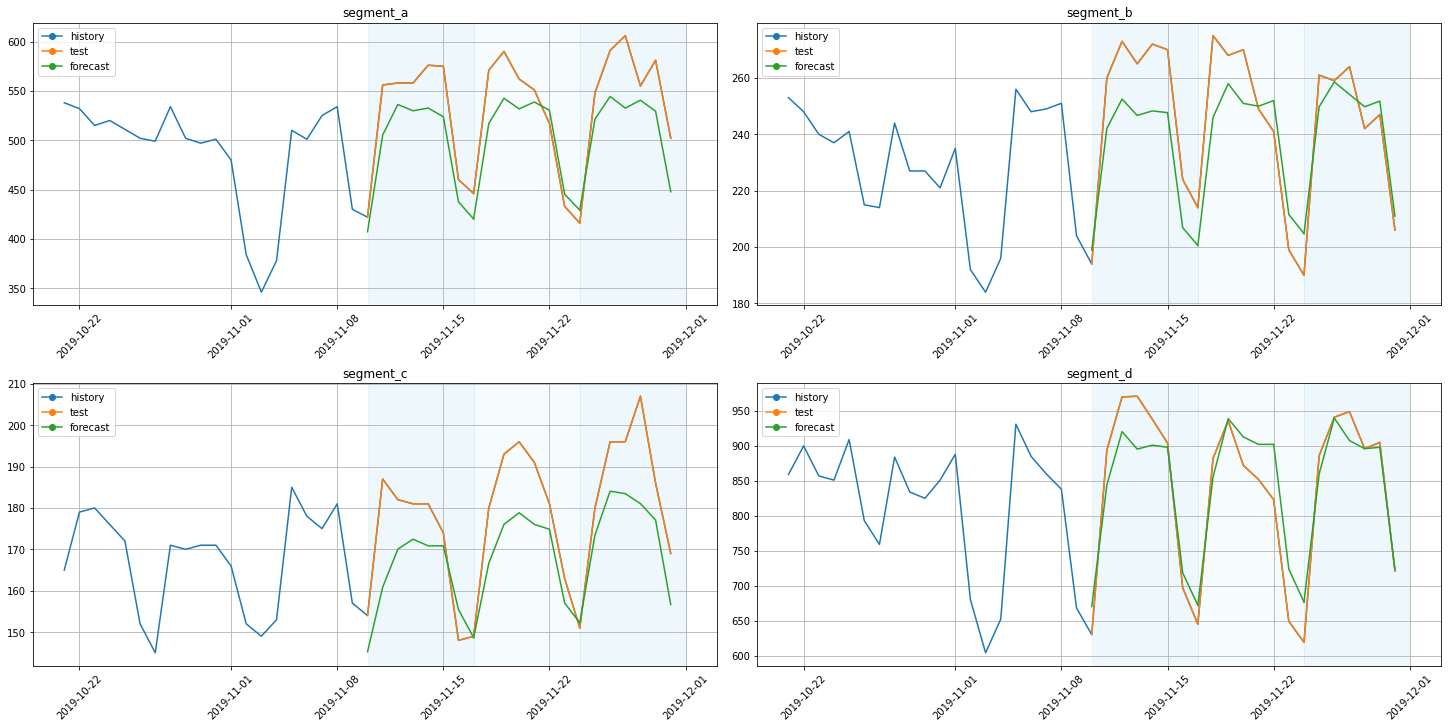

In [24]:
plot_backtest(forecast_sma, ts, history_len=20)

As we can see, neural networks are a bit better in this particular case.

## 4. Etna native deep models<a class="anchor" id="chapter4"></a>

We've used models from pytorch-forecasting above. Now let's talk about etna native implementations of deep models for time series.  
There is small thing to change: we dont need special `PytorchForecastingTransform` now.

We'll use RNN model based on LSTM cell

In [25]:
from etna.models.nn import RNNModel
from etna.transforms import StandardScalerTransform

In [26]:
model_rnn = RNNModel(
    decoder_length=HORIZON,
    encoder_length=2 * HORIZON,
    input_size=11,
    trainer_params=dict(max_epochs=5),
    lr=1e-3,
)

pipeline_rnn = Pipeline(
    model=model_rnn,
    horizon=HORIZON,
    transforms=[StandardScalerTransform(in_column="target"), transform_lag],
)

In [27]:
metrics_rnn, forecast_rnn, fold_info_rnn = pipeline_rnn.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.9s finished


In [28]:
score = metrics_rnn["SMAPE"].mean()
print(f"Average SMAPE for LSTM: {score:.3f}")

Average SMAPE for LSTM: 6.402


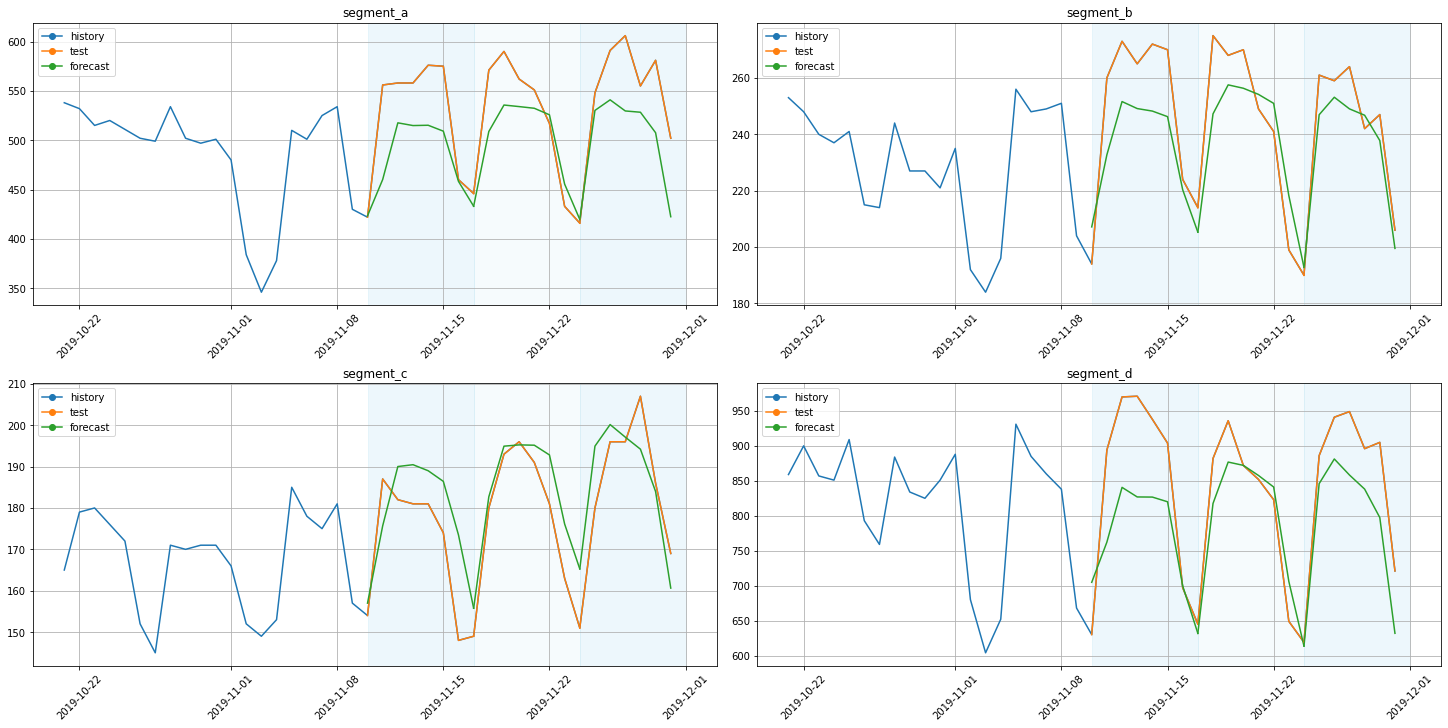

In [29]:
plot_backtest(forecast_rnn, ts, history_len=20)